# Sound speed as a source of modified gravity

In Horndeski theory, the dark energy sound speed is given by the basis functions $\alpha_M$, $\alpha_B$, $\alpha_K$ and $\alpha_T$. The term $\alpha_T$ is assumed to be zero. We can further assume $M_* = 1$, implying $\alpha_M = 0$. We obtain:

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(\frac{3}{2}(1 + w_t) + \frac{\alpha_B}{2} \right) + 3(1 + w_t).
\end{equation}

In terms of the $\mu-\Sigma$ parametrization, we find

\begin{equation}
    \mu = \Sigma = 1 + \frac{\alpha_B^2}{2c_s^2\left(\alpha_K + \frac{3}{2}\alpha_B^2\right)}
\end{equation}

Let's explore the solutions for $\alpha_B$ and $\mu$ assuming a cubic galileon parametrization

\begin{equation}
    \alpha_K = c_2\frac{H_0^4}{H^4}\Omega_\mathrm{DE} + 6\alpha_B
\end{equation}

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from engine import *

## One Cosmology

Text(0, 0.5, '$\\mu$')

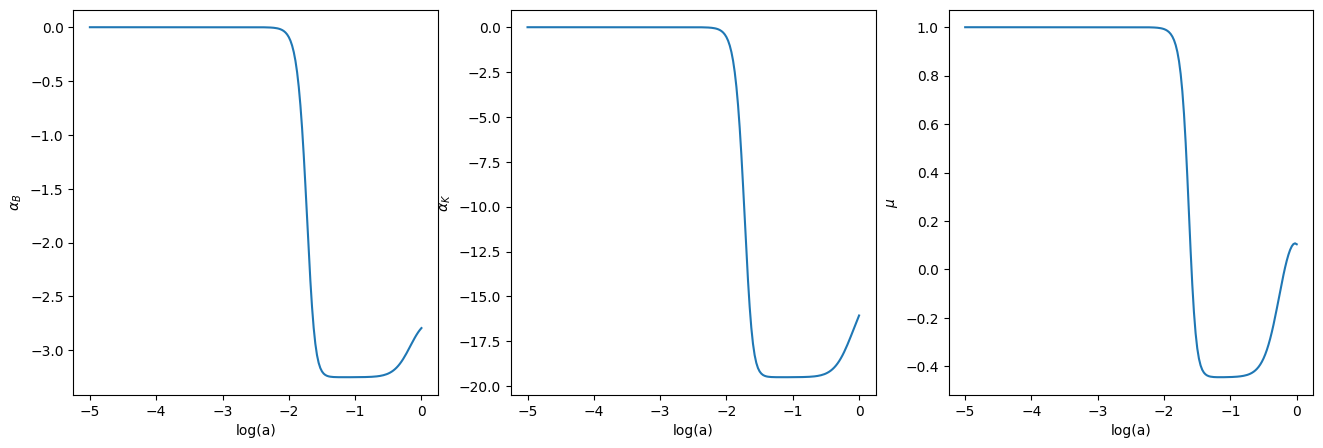

In [8]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.838,
    "wa": -0.62,
    "cs2": 1,
    "alpha_K_0": 1,
    # "alpha_B_init": 0
}

log_a, alpha_B, alpha_K, mu = solve_alpha_B(aktype=alphaKtype.CUGAL, **reference_cosmo)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(log_a, alpha_B)
axs[0].set_xlabel("log(a)")
axs[0].set_ylabel("$\\alpha_B$")
axs[1].plot(log_a, alpha_K)
axs[1].set_xlabel("log(a)")
axs[1].set_ylabel("$\\alpha_K$")
axs[2].plot(log_a, mu)
axs[2].set_xlabel("log(a)")
axs[2].set_ylabel("$\\mu$")

## Sampling across parameter space

### 1. Star Sampling

/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:92: RuntimeWarning: invalid value encountered in scalar divide
  mu[0]      = 1 + alpha_B[0]**2/2/(alpha_K[0] + 1.5*alpha_B[0]**2)/cs2
/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:106: RuntimeWarning: invalid value encountered in scalar divide
  mu[i+1]      = 1 + alpha_B[i+1]**2/2/(alpha_K[i+1] + 1.5*alpha_B[i+1]**2)/cs2
/home/joao/cosmo/cs2-project/mu_solutions_study/engine.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  mu[i+1]      = 1 + alpha_B[i+1]**2/2/(alpha_K[i+1] + 1.5*alpha_B[i+1]**2)/cs2


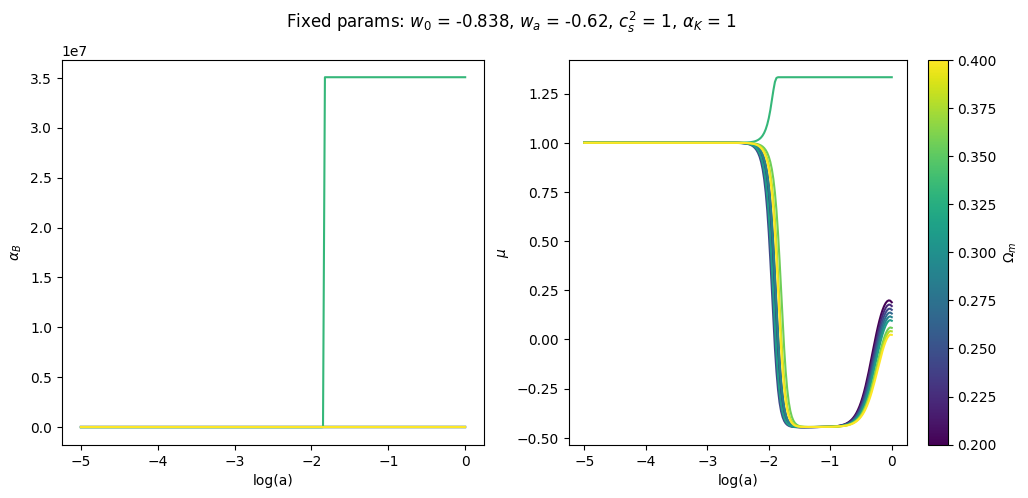

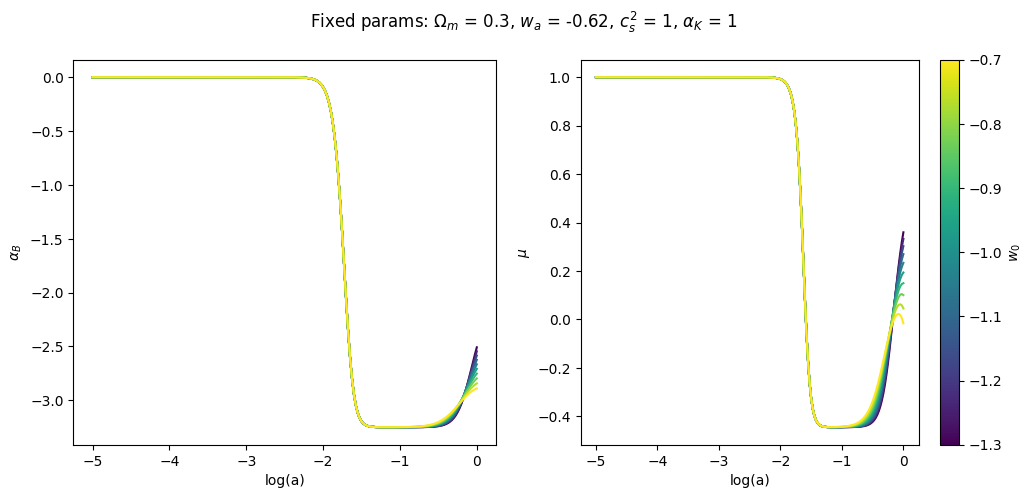

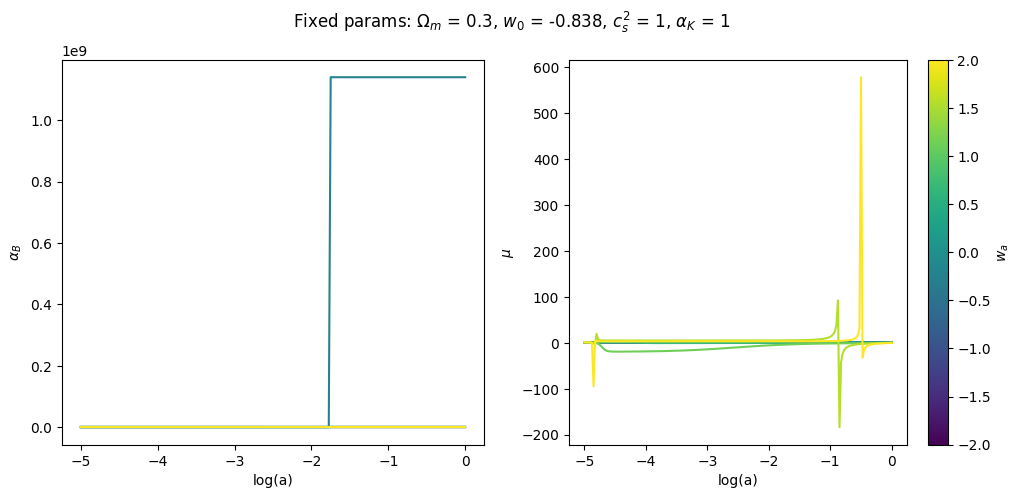

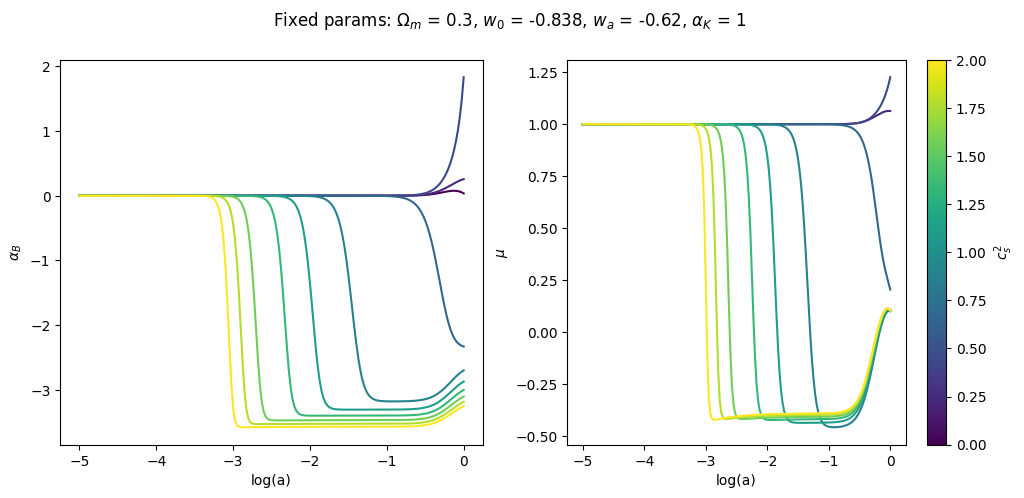

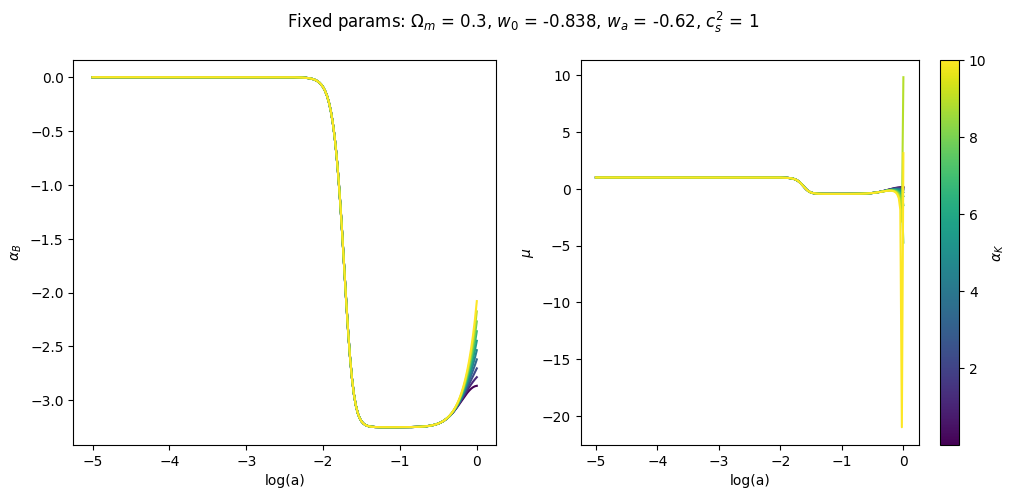

In [9]:
grids = {
    "omega_m": np.linspace(0.2, 0.4, 10),
    "w0"     : np.linspace(-1.3, -0.7, 10),
    "wa"     : np.linspace(-2, 2, 10),
    "cs2"    : np.linspace(0, 2, 10),
    "alpha_K_0": np.linspace(1e-3, 10, 10),
    # "alpha_B_init": np.linspace(-1, 1, 10), # NOTE: solution converges to attractor quickly
}

param_name_latex = {
    "omega_m": "$\\Omega_m$",
    "w0"     : "$w_0$",
    "wa"     : "$w_a$",
    "cs2"    : "$c_s^2$",
    "alpha_K_0": "$\\alpha_K$",
}

cmap = plt.get_cmap('viridis')

for param_name in grids.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    params = reference_cosmo.copy()
    norm = mpl.colors.Normalize(vmin=grids[param_name][0], vmax=grids[param_name][-1])
    for param_value in grids[param_name]:
        params[param_name] = param_value
        loga, alpha_B, alpha_K, mu = solve_alpha_B(aktype=alphaKtype.CUGAL, **params)
        color = cmap(norm(param_value))
        axs[0].plot(loga, alpha_B, color=color)
        axs[1].plot(loga, mu, color=color)
    for ax in axs:
        ax.set_xlabel("log(a)")
    axs[0].set_ylabel("$\\alpha_B$")
    axs[1].set_ylabel("$\\mu$")
    
    del params[param_name]
    title = ", ".join([" = ".join((param_name_latex[name], f"{value}")) for (name, value) in params.items()])
    fig.suptitle(f"Fixed params: {title}")

    # Create a ScalarMappable for the colorbar (no data required)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # for colorbar compatibility

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(param_name_latex[param_name])
    plt.savefig(f"plots/cugal/{param_name}_scan.pdf")

### 2. Random Sampling

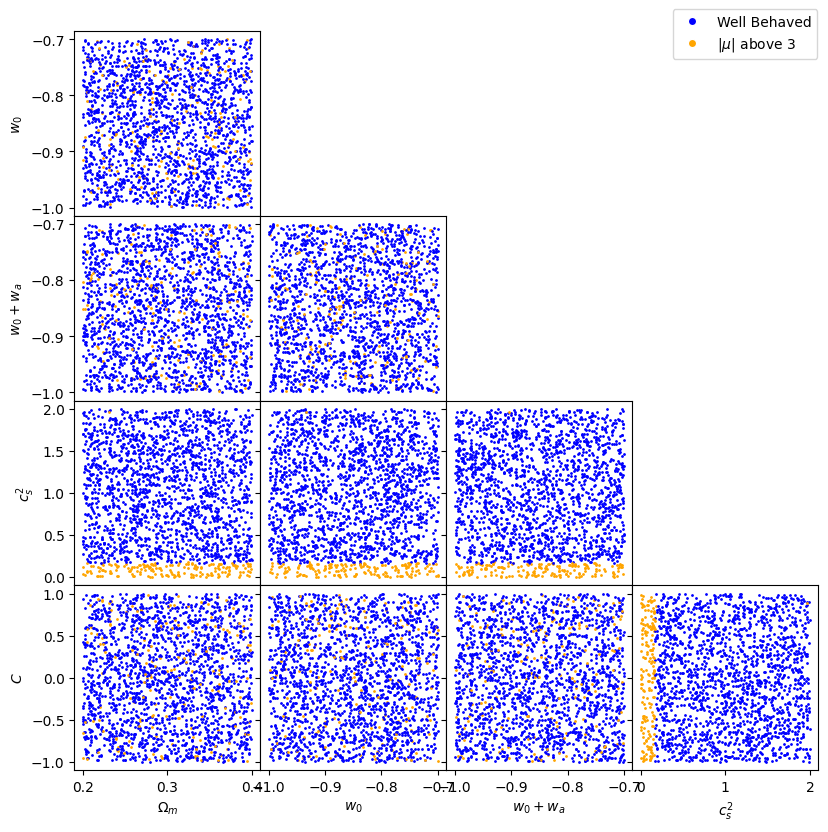

In [ ]:
priors = {
    "omega_m": [0.2, 0.4],
    "w0"     : [-1.0, -0.7],
    "w0pwa"  : [-1.0, -0.7],
    "cs2"    : [0, 2],
    "C"      : [-1, 1],
}
priors_array = np.array(list(priors.values()))

alpha_B_threshold = 100
mu_threshold = 3

samples = []
for i in range(2_000):
    params = np.random.rand(len(priors))*(priors_array[:,1]-priors_array[:,0]) + priors_array[:,0]
    params_dict = dict(zip(priors.keys(), params))
    log_a, alpha_B, mu = solve_alpha_B(**params_dict, method="euler")
    # if np.any(alpha_B > alpha_B_threshold) or np.any(alpha_B < -alpha_B_threshold):
    #     samples.append((params, "red"))
    if np.any(mu > mu_threshold) or np.any(mu < -mu_threshold):
        samples.append((params, "orange"))
    else:
        samples.append((params, "blue"))


fig, axs = plt.subplots(len(params), len(params), figsize=(12, 12), gridspec_kw={"hspace": 0, "wspace": 0})
for row in range(len(params)):
    for col in range(len(params)):
        ax = axs[row, col]
        if row == len(params)-1: ax.set_xlabel(list(param_name_latex.values())[col])
        else: ax.set_xticklabels([])
        if col == 0:             ax.set_ylabel(list(param_name_latex.values())[row])
        else: ax.set_yticklabels([])
            
        if col >= row: ax.remove()
        for sample in samples:
            point, color = sample
            ax.scatter(point[col], point[row], color=color, s=1)

blue_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="blue", label="Well Behaved", )
orange_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="orange", label=f"$|\\mu|$ above {mu_threshold}", )
fig.legend(handles=[blue_circle, orange_circle], bbox_to_anchor=(0.75, 0.75))

plt.savefig("plots/cugal/alpha_B_samples.pdf", bbox_inches="tight")